0


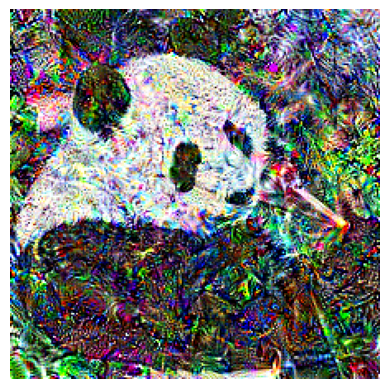

1


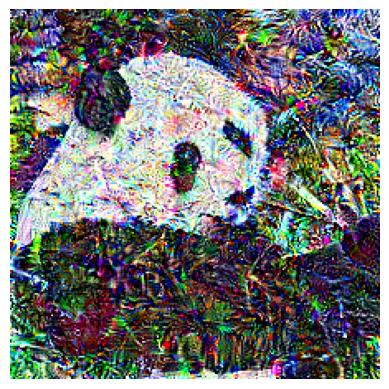

2


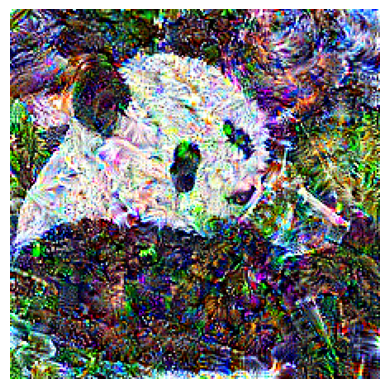

3


KeyboardInterrupt: 

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def preprocess_image(image_path, image_size=224):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    img = transform(image).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")
    img.requires_grad = True
    return img

def deprocess_image(img_tensor):
    img = img_tensor.detach().cpu().numpy().squeeze()
    img = np.transpose(img, (1, 2, 0))  # Convert from CHW to HWC
    img = (img - img.min()) / (img.max() - img.min())  # Normalize
    return img

def feature_visualization(model, layer_name, neuron_index, image_path, lr=0.1, steps=100, image_size=224):
    model.to(device).eval()  # Move model to device (CPU or GPU)
    
    img = preprocess_image(image_path, image_size)  # Generate random input image
    optimizer = optim.Adam([img], lr=lr)

    layer_output = None
    def hook_fn(module, input, output):
        nonlocal layer_output
        layer_output = output

    layer = dict([*model.named_modules()]).get(layer_name)
    if layer is None:
        raise ValueError(f"Layer {layer_name} not found in the model.")
    
    hook = layer.register_forward_hook(hook_fn)

    for step in range(steps):
        optimizer.zero_grad()
        model(img)
        loss = -layer_output[0, neuron_index].mean()  # Maximize neuron activation
        loss.backward()
        optimizer.step()
        
        img.data = torch.clamp(img.data, -1, 1)  # Regularization

        #if step % 10 == 0:
        #    print(f"Step {step}, Loss: {loss.item()}")

    hook.remove()
    return deprocess_image(img)

# Load a pre-trained ResNet and visualize a neuron
model = models.resnet50(pretrained=True).to(device)
for i in range(2048):
    print(i)
    neuron_image = feature_visualization(model, "layer4.2.conv3", neuron_index=i, image_path="Ressources/panda.jpg")
    plt.imshow(neuron_image)
    plt.axis("off")
    plt.show()

In [9]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the pre-trained model
model = models.resnet50(pretrained=True)
model.eval()

# Define the image preprocessing function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Store activations for tracking
activations = {}

# Hook function to capture activations
def hook_fn(module, input, output):
    activations['layer4.1.conv1'] = output

# Register hook to capture output from a specific layer
layer = model.layer4[1].conv1  # Example layer
hook = layer.register_forward_hook(hook_fn)


c:\Users\nasta\miniconda3\envs\adaexam\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nasta\miniconda3\envs\adaexam\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Load the image
image_path = "Ressources/weasel.jpg"
image = preprocess_image(image_path)

# Perform a forward pass through the model
with torch.no_grad():
    model(image)

# Remove the hook after capturing activations
hook.remove()

# Get the activation map for the layer
activation = activations['layer4.1.conv1']


Neuron 471 fires for this image.


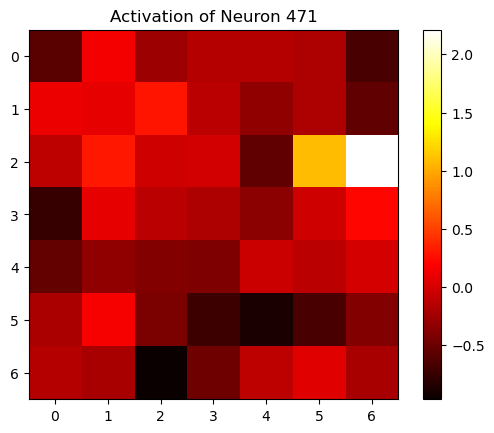

In [ ]:
# Visualize the activation map for a specific neuron (e.g., neuron 0)
neuron_idx = 471
activation_map = activation[0, neuron_idx, :, :].cpu().numpy()

# Plot the activation of the neuron
plt.imshow(activation_map, cmap='hot')
plt.colorbar()
plt.title(f'Activation of Neuron {neuron_idx}')
plt.show()

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Load the pre-trained model
model = models.resnet50(pretrained=True)
model.eval()

# Define the image preprocessing function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor, image

def show_activation_map(image_path, layer_name, layer, neuron_idx):
    # Store activations for tracking
    activations = {}

    # Hook function to capture activations
    def hook_fn(module, input, output):
        print(f"Layer {layer_name} output shape: {output.shape}")
        activations[layer_name] = output

    # Register hook to capture output from a specific layer
    hook = layer.register_forward_hook(hook_fn)

    # Load the image and original PIL image
    image_tensor, original_image = preprocess_image(image_path)

    # Perform a forward pass through the model
    with torch.no_grad():
        model(image_tensor)

    # Remove the hook after capturing activations
    hook.remove()

    # Get the activation map for the layer
    activation = activations[layer_name]

    # Process activation map
    activation_map = activation[0, neuron_idx, :, :].cpu()

    # Resize activation map to match original image size
    activation_map_resized = F.interpolate(
        activation_map.unsqueeze(0).unsqueeze(0),
        size=(224, 224),
        mode='bilinear',
        align_corners=False
    )[0, 0].numpy()

    # Convert original image to numpy array and denormalize
    img_np = image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)

    # Create the visualization
    plt.figure(figsize=(10, 5))

    # Plot
    plt.imshow(img_np)
    overlay = plt.imshow(
        activation_map_resized, 
        cmap='viridis', 
        alpha=0.6,  # --
        interpolation='bilinear'
    )
    plt.colorbar(overlay, label='Activation strength')
    plt.title(f'Neuron {layer_name}:{neuron_idx} activation overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

c:\Users\nasta\miniconda3\envs\adaexam\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nasta\miniconda3\envs\adaexam\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer layer4.1.conv1 output shape: torch.Size([1, 512, 7, 7])


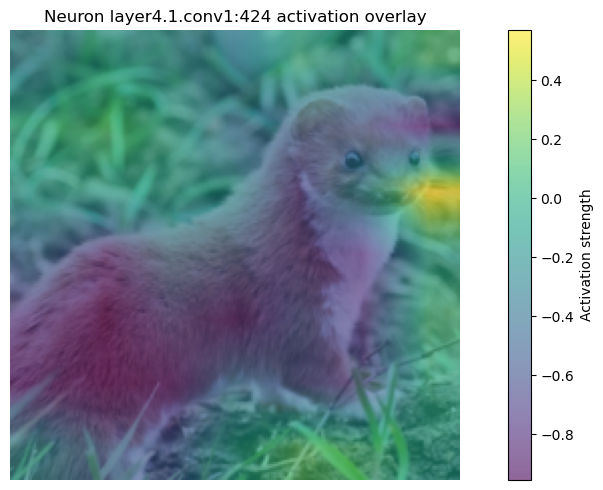

Layer layer4.1.conv1 output shape: torch.Size([1, 512, 7, 7])


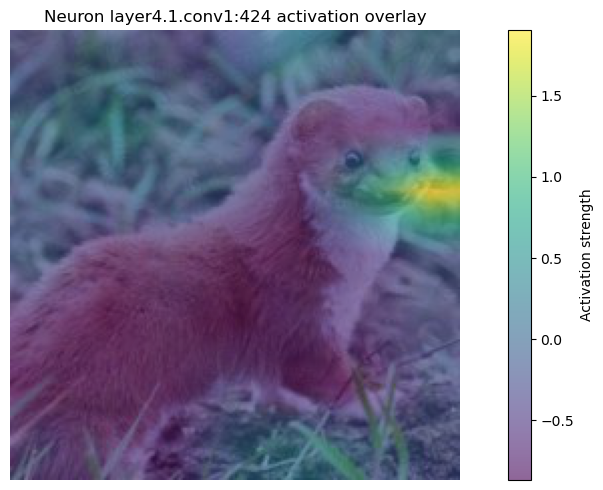

Layer layer4.1.conv1 output shape: torch.Size([1, 512, 7, 7])


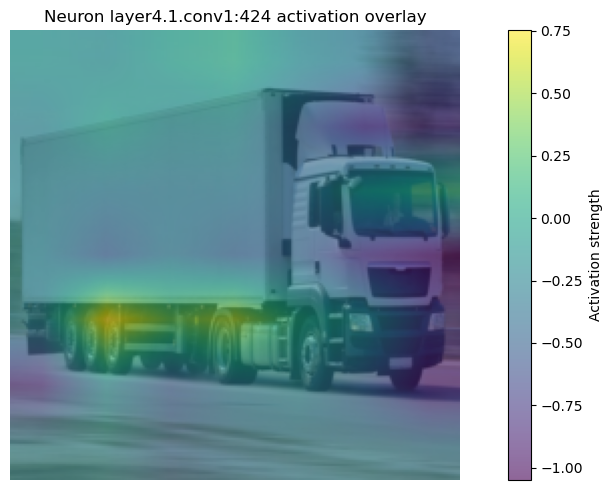

Layer layer4.1.conv1 output shape: torch.Size([1, 512, 7, 7])


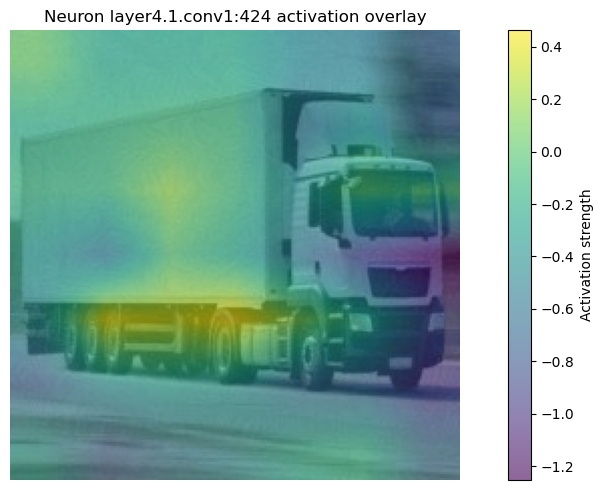

In [75]:
#image_path = "output/weasel_as_panda.jpg"
layer_name = "layer4.1.conv1"
layer = model.layer4[1].conv1
neuron_idx = 424

# show_activation_map("Ressources/panda.jpg", layer_name, layer, neuron_idx)
# show_activation_map("output/panda_perturbed.jpg", layer_name, layer, neuron_idx)
show_activation_map("Ressources/weasel.jpg", layer_name, layer, neuron_idx)
# show_activation_map("output/weasel_as_panda.jpg", layer_name, layer, neuron_idx)
show_activation_map("output/weasel_as_truck.jpg", layer_name, layer, neuron_idx)
show_activation_map("Ressources/trailer_truck.jpg", layer_name, layer, neuron_idx)
show_activation_map("output/truck_as_weasel.jpg", layer_name, layer, neuron_idx)

c:\Users\nasta\miniconda3\envs\adaexam\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nasta\miniconda3\envs\adaexam\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\nasta\AppData\Local\Temp/ipykernel_2904/305933488.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


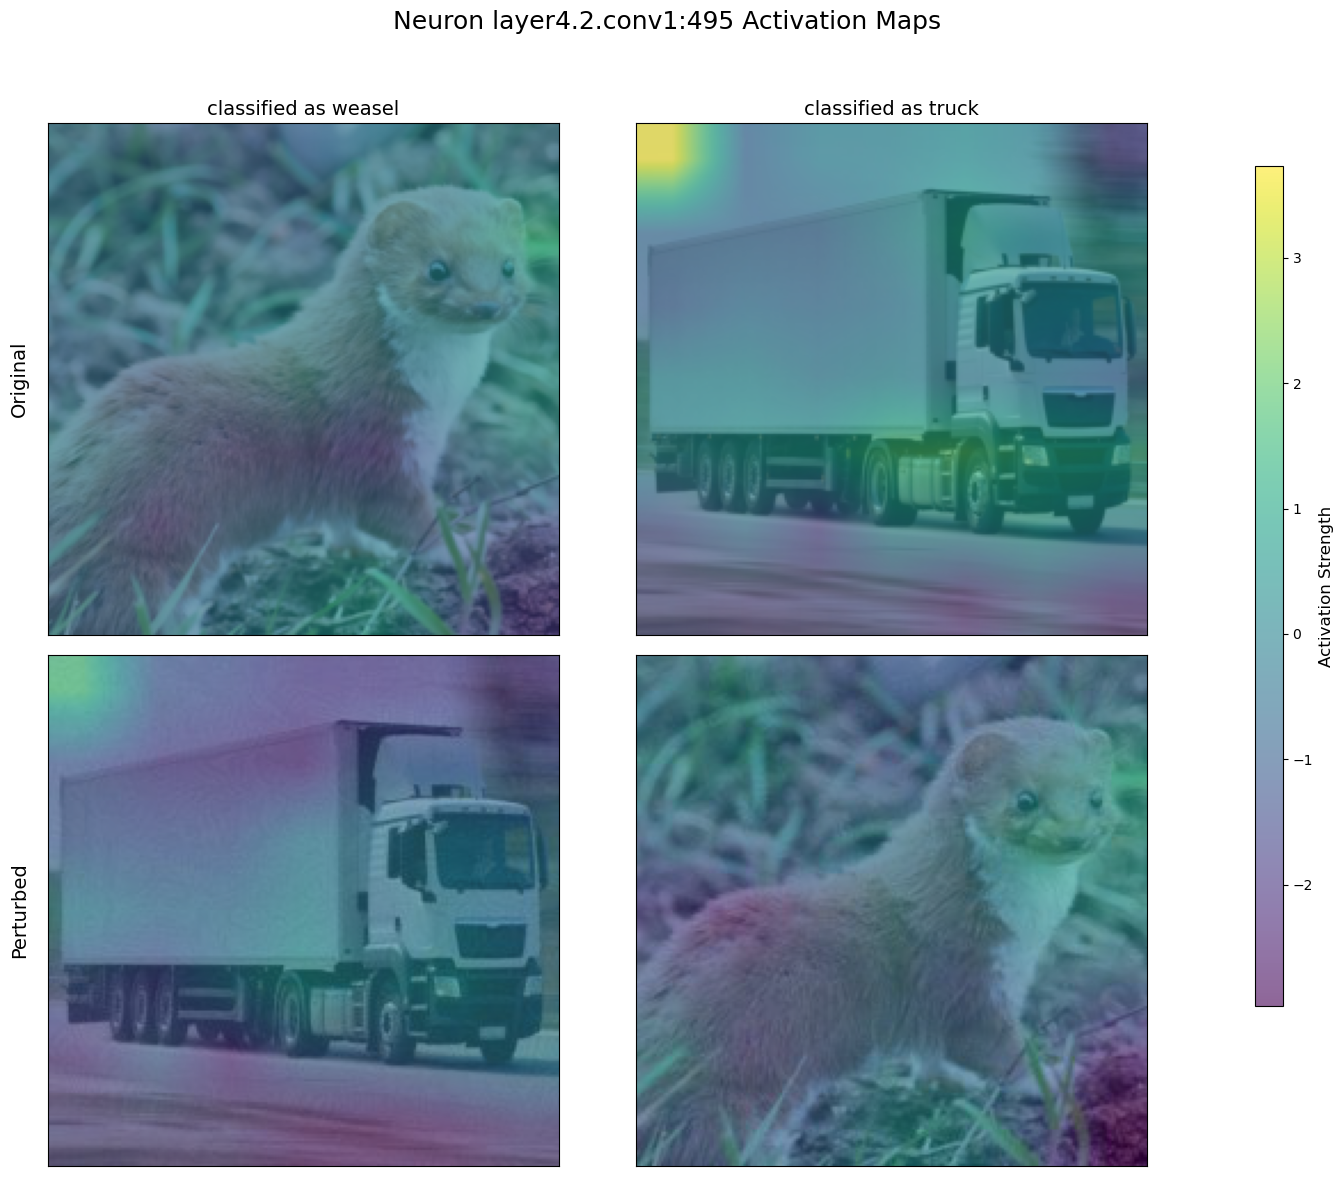

In [14]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Load the pre-trained model
model = models.resnet50(pretrained=True)
model.eval()

# Define the image preprocessing function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor, image

def get_activation_map(image_path, layer_name, layer, neuron_idx):
    # Store activations for tracking
    activations = {}

    # Hook function to capture activations
    def hook_fn(module, input, output):
        activations[layer_name] = output

    # Register hook to capture output from a specific layer
    hook = layer.register_forward_hook(hook_fn)

    # Load the image and original PIL image
    image_tensor, original_image = preprocess_image(image_path)

    # Perform a forward pass through the model
    with torch.no_grad():
        model(image_tensor)

    # Remove the hook after capturing activations
    hook.remove()

    # Get the activation map for the layer
    activation = activations[layer_name]

    # Process activation map
    activation_map = activation[0, neuron_idx, :, :].cpu()

    # Resize activation map to match original image size
    activation_map_resized = F.interpolate(
        activation_map.unsqueeze(0).unsqueeze(0),
        size=(224, 224),
        mode='bilinear',
        align_corners=False
    )[0, 0].numpy()

    # Convert original image to numpy array and denormalize
    img_np = image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)
    
    return img_np, activation_map_resized

def show_activation_maps_grid(layer_name, layer, neuron_idx):
    # Image paths
    weasel_path = "Ressources/weasel.jpg"
    weasel_as_truck_path = "output/weasel_as_truck.jpg"
    truck_path = "Ressources/trailer_truck.jpg"
    truck_as_weasel_path = "output/truck_as_weasel.jpg"
    
    # Create figure with 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))
    
    # Get activation maps and images
    weasel_img, weasel_act = get_activation_map(weasel_path, layer_name, layer, neuron_idx)
    weasel_truck_img, weasel_truck_act = get_activation_map(weasel_as_truck_path, layer_name, layer, neuron_idx)
    truck_img, truck_act = get_activation_map(truck_path, layer_name, layer, neuron_idx)
    truck_weasel_img, truck_weasel_act = get_activation_map(truck_as_weasel_path, layer_name, layer, neuron_idx)
    
    # Plot each image+activation
    images = [weasel_img, truck_img, truck_weasel_img, weasel_truck_img]
    acts = [weasel_act, truck_act, truck_weasel_act, weasel_truck_act]
    titles = ["classified as weasel", "classified as truck", "", ""]
    
    # Find global min/max for consistent colormap
    vmin = min(act.min() for act in acts)
    vmax = max(act.max() for act in acts)
    
    # Create plots
    overlays = []
    for i, (ax, img, act, title) in enumerate(zip(axs.flatten(), images, acts, titles)):
        ax.imshow(img)
        overlay = ax.imshow(act, cmap='viridis', alpha=0.6, interpolation='bilinear',
                           vmin=vmin, vmax=vmax)
        overlays.append(overlay)
        ax.set_title(title, fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add row and column labels
        if i == 0:
            ax.set_ylabel("Original", fontsize=14, labelpad=10)
        elif i == 2:
            ax.set_ylabel("Perturbed", fontsize=14, labelpad=10)
            
    # Add column labels
    # fig.text(0.25, 0.95, "Weasel", ha='center', va='center', fontsize=16)
    # fig.text(0.75, 0.95, "Truck", ha='center', va='center', fontsize=16)
    
    # Add a global colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(overlays[0], cax=cbar_ax)
    cbar.set_label('Activation Strength', fontsize=12)
    
    plt.suptitle(f'Neuron {layer_name}:{neuron_idx} Activation Maps', fontsize=18, y=0.98)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()

# Define parameters
layer_name = "layer4.2.conv1"
layer = model.layer4[2].conv1
neuron_idx = 495

# Show all four activation maps in a single grid
show_activation_maps_grid(layer_name, layer, neuron_idx)